<h1 align="center">Healthcare Image Authenticity Project</h1>


# Install requirements

In [1]:
!pip install medmnist torch torchvision matplotlib pandas seaborn scikit-learn opencv-python captum --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.8 MB/s eta 0:00:00


# Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import copy
import os
import medmnist
import json
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader, random_split, SubsetRandomSampler, Subset
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,precision_score, 
    recall_score, f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.decomposition import PCA
from medmnist import INFO
from sklearn.manifold import TSNE
from scipy.fft import fft2, fftshift
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from captum.attr import LayerGradCam, LayerAttribution, IntegratedGradients

sns.set_style('whitegrid')

random.seed(42)
np.random.seed(42)
torch.manual_seed(42); 

# Load Data and Transform

### 1. Load Multiple MedMNIST Subsets (OrganAMNIST &  OrganSMNIST & OrganCMNIST & ChestMNIST)
 

In [3]:
dataset_names = ['organamnist','organsmnist','organcmnist','chestmnist']
data = {}

for name in dataset_names:
    info       = INFO[name]
    DataClass  = getattr(medmnist, info['python_class'])
    ds_train   = DataClass(split='train', download=True, as_rgb=True)
    ds_test    = DataClass(split='test',  download=True, as_rgb=True)

    # grab raw arrays
    imgs_train, imgs_test = ds_train.imgs, ds_test.imgs
    labels_train = ds_train.labels.flatten()
    labels_test  = ds_test.labels.flatten()

    # ensure train and test are (N, H, W, C)
    def fix_dims(imgs):
        # if 3-D, add channel axis
        if imgs.ndim == 3:
            imgs = np.expand_dims(imgs, axis=-1)      
        # if only 1 channel, repeat to make it RGB
        if imgs.shape[-1] == 1:
            imgs = np.repeat(imgs, 3, axis=-1)
        return imgs

    imgs_train = fix_dims(imgs_train)
    imgs_test  = fix_dims(imgs_test)

    # now concatenate
    imgs   = np.concatenate([imgs_train,  imgs_test ], axis=0) 
    labels = np.concatenate([labels_train, labels_test], axis=0)

    data[name] = {'imgs': imgs, 'labels': labels}
    print(f"Loaded {name}: imgs {imgs.shape}, labels {labels.shape}")

100%|██████████| 38.2M/38.2M [00:02<00:00, 14.5MB/s]


Loaded organamnist: imgs (52339, 28, 28, 3), labels (52339,)


100%|██████████| 16.5M/16.5M [00:01<00:00, 12.2MB/s]


Loaded organsmnist: imgs (22759, 28, 28, 3), labels (22759,)


100%|██████████| 15.5M/15.5M [00:01<00:00, 11.7MB/s]


Loaded organcmnist: imgs (21191, 28, 28, 3), labels (21191,)


100%|██████████| 82.8M/82.8M [01:35<00:00, 868kB/s] 


Loaded chestmnist: imgs (100901, 28, 28, 3), labels (1412614,)


### 2. Combine datasets

In [4]:
X = np.concatenate([data[n]['imgs'] for n in dataset_names], axis=0)
y_orig = np.concatenate([data[n]['labels'] for n in dataset_names], axis=0)
print(f"Combined dataset shape: {X.shape}")

Combined dataset shape: (197190, 28, 28, 3)


### 3. Define Tampering Functions

In [5]:
def add_square_patch(img, size=10):
    h, w, _ = img.shape
    x = np.random.randint(0, h-size)
    y = np.random.randint(0, w-size)
    img2 = img.copy()
    img2[x:x+size, y:y+size] = 255
    return img2

def add_gaussian_noise(img, mean=0, var=0.01):
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, img.shape) * 255
    img2 = img + gauss
    return np.clip(img2, 0, 255)

def add_salt_pepper_noise(img, amount=0.005):
    img2 = img.copy()
    num_salt = np.ceil(amount * img.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape[:2]]
    img2[coords[0], coords[1], :] = 255
    num_pepper = np.ceil(amount * img.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape[:2]]
    img2[coords[0], coords[1], :] = 0
    return img2

def add_blur(img, ksize=(7,7)):
    return cv2.GaussianBlur(img, ksize, 0)

def change_contrast(img, alpha=1.5, beta=0):
    img2 = img.astype(np.float32) * alpha + beta
    return np.clip(img2, 0, 255)

# List of techniques
techniques = {
    'patch': add_square_patch,
    'gaussian_noise': add_gaussian_noise,
    'salt_pepper': add_salt_pepper_noise,
    'blur': add_blur,
    'contrast': change_contrast
}

In [6]:
tech_labels = []
X_tampered  = np.empty_like(X)
num = X.shape[0]

for i in range(num):
    tech_name, func = random.choice(list(techniques.items()))
    X_tampered[i] = func(X[i])
    tech_labels.append(tech_name)

tech_labels = np.array(tech_labels)
print("Tampering applied:", np.unique(tech_labels, return_counts=True))

Tampering applied: (array(['blur', 'contrast', 'gaussian_noise', 'patch', 'salt_pepper'],
      dtype='<U14'), array([39462, 39296, 39740, 39266, 39426]))


### 5. Combine real vs tampered

In [7]:
X_all = np.concatenate([X, X_tampered], axis=0)
y_all = np.concatenate([np.zeros(num), np.ones(num)], axis=0)
tech_all = np.concatenate([np.array(['original']*num), tech_labels], axis=0)

X_train, X_test, y_train, y_test, tech_train, tech_test = train_test_split(
    X_all, y_all, tech_all, test_size=0.25, random_state=42, stratify=y_all)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (295785, 28, 28, 3), Test size: (98595, 28, 28, 3)


# Advanced EDA with Multiple Tampering Techniques

### 1. EDA: Tampering Technique Distribution


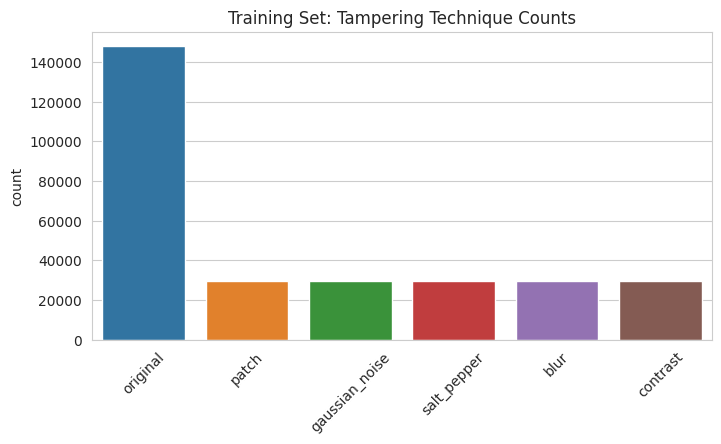

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x=tech_train, order=['original']+list(techniques.keys()))
plt.title('Training Set: Tampering Technique Counts')
plt.xticks(rotation=45)
plt.show()

### 2. EDA: Sample images by technique


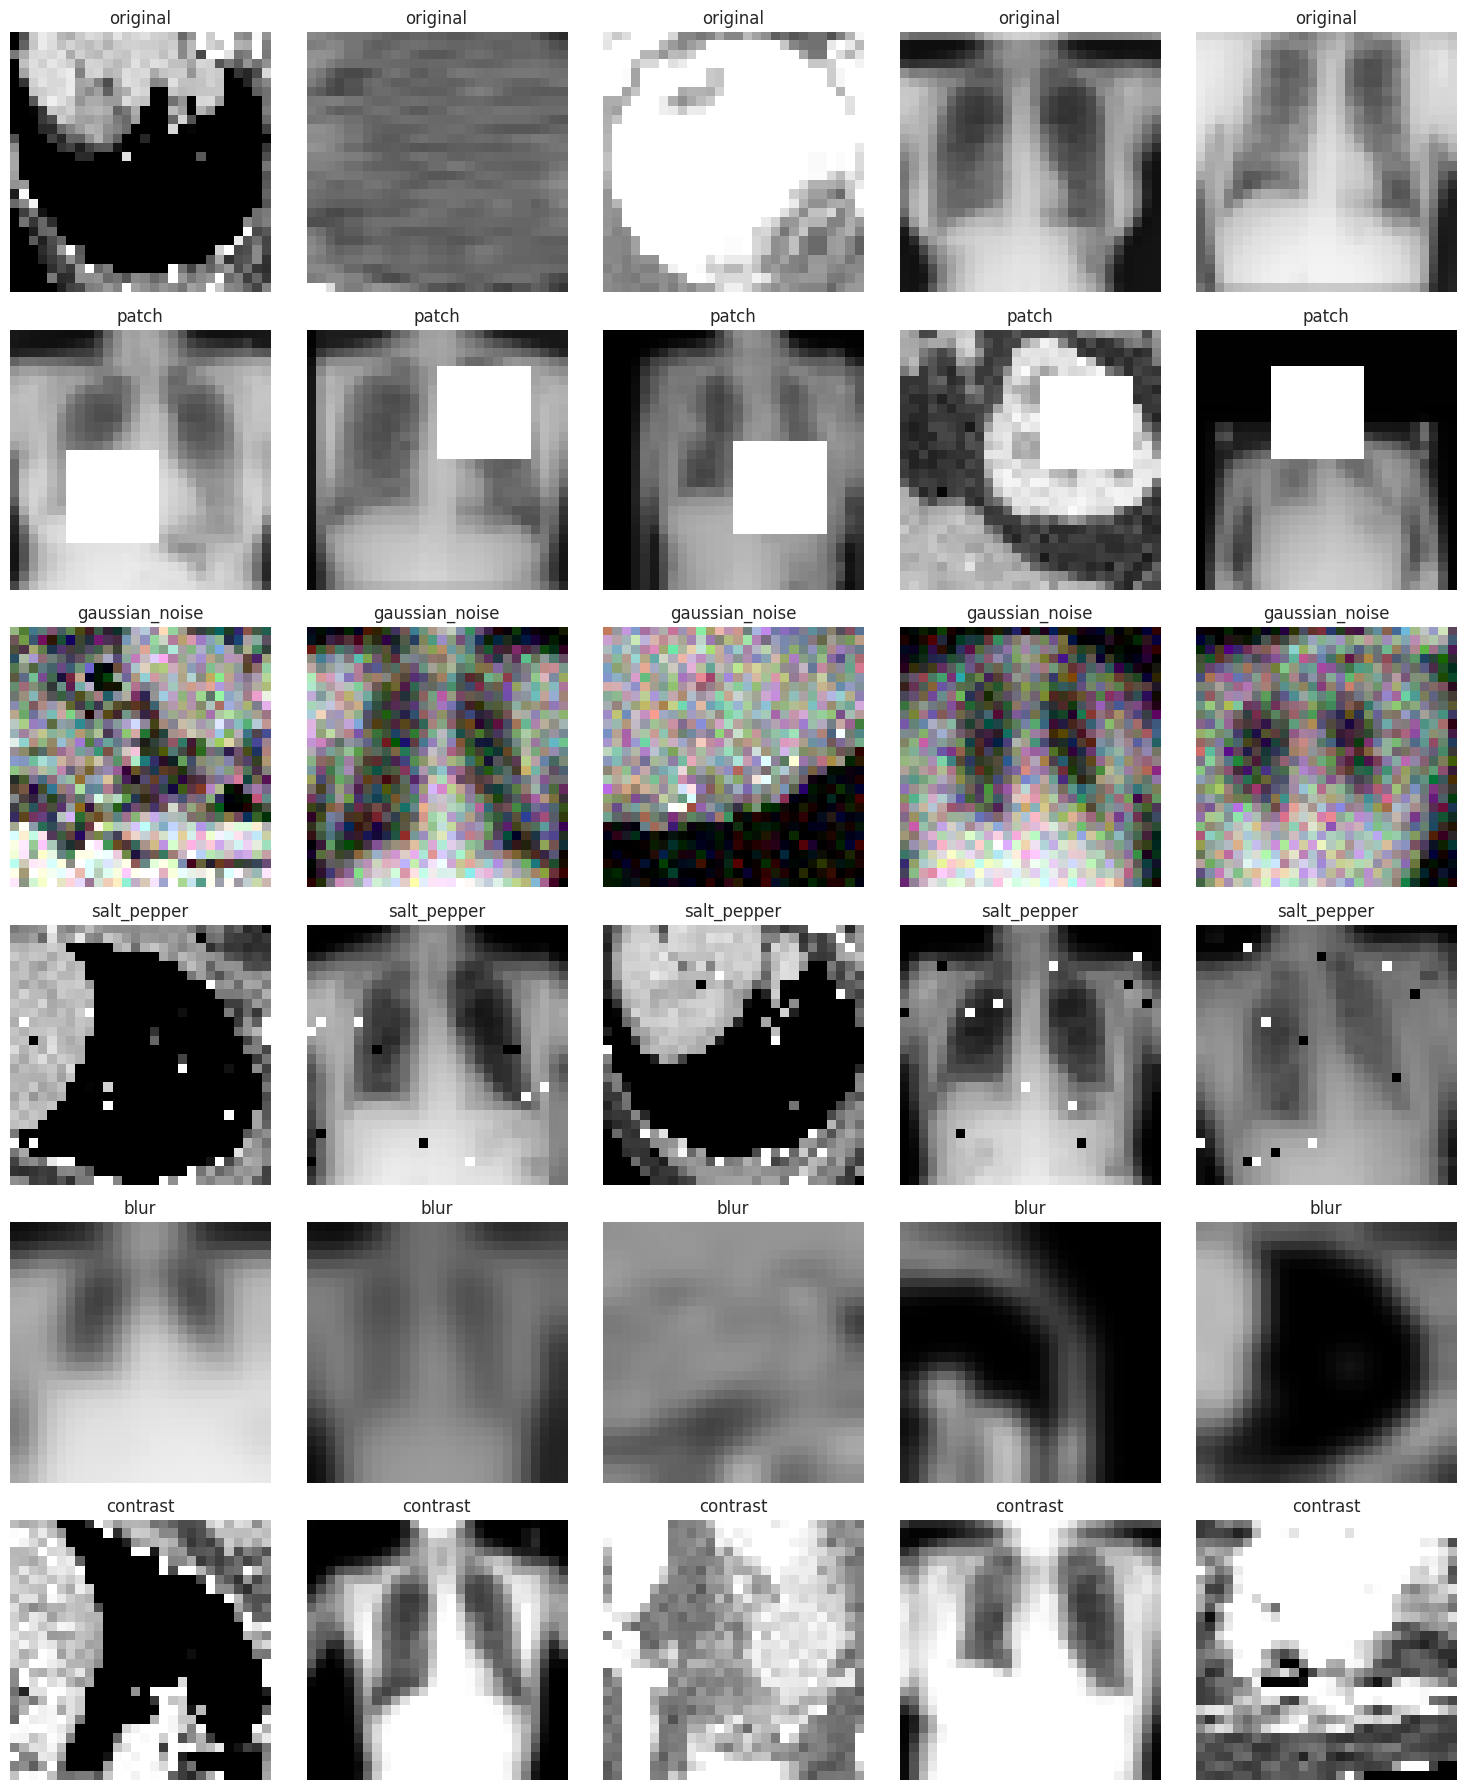

In [9]:
fig, axes = plt.subplots(len(techniques)+1, 5, figsize=(15,3*(len(techniques)+1)))
technique_list = ['original'] + list(techniques.keys())
for i, tech in enumerate(technique_list):
    mask = (tech_train == tech)
    idxs = np.where(mask)[0][:5]
    for j, idx in enumerate(idxs):
        axes[i,j].imshow(X_train[idx].astype(np.uint8))
        axes[i,j].axis('off')
        axes[i,j].set_title(tech)
plt.tight_layout()
plt.show()

### 3. EDA: PCA on Mean/Std Features colored by technique

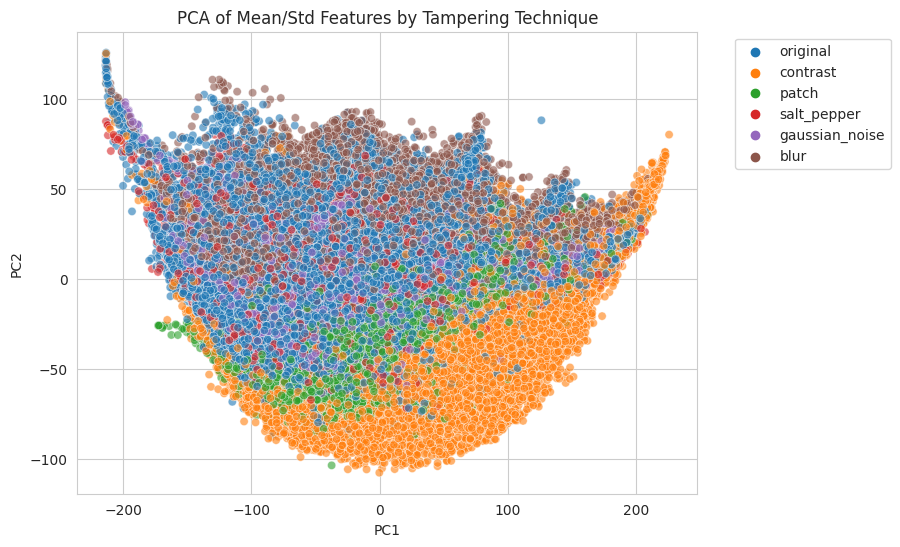

In [10]:
features = []
labels = tech_train
for img in X_train:
    feats = [img[:,:,c].mean() for c in range(3)] + [img[:,:,c].std() for c in range(3)]
    features.append(feats)
features = np.array(features)

pca = PCA(n_components=2)
proj = pca.fit_transform(features)
df_pca = pd.DataFrame(proj, columns=['PC1','PC2'])
df_pca['technique'] = labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='technique', alpha=0.6)
plt.title('PCA of Mean/Std Features by Tampering Technique')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 4. Mean Image Difference Heatmap

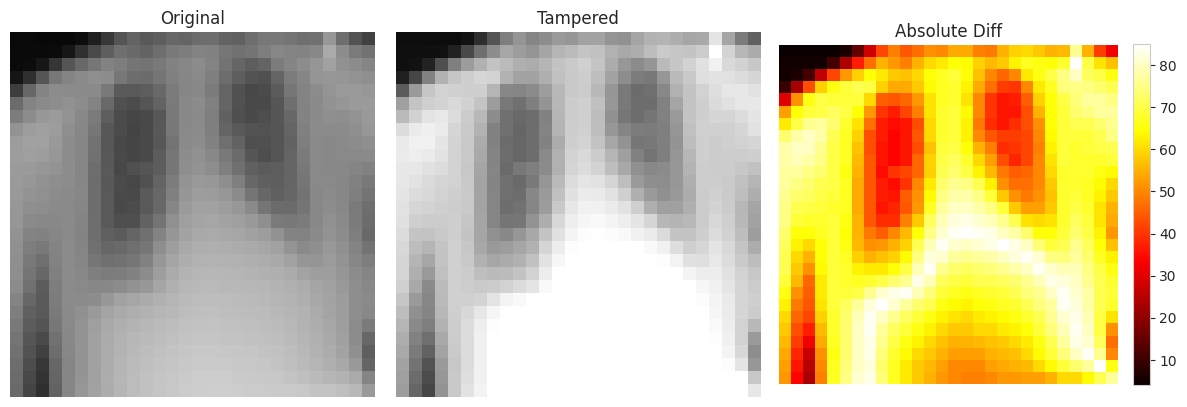

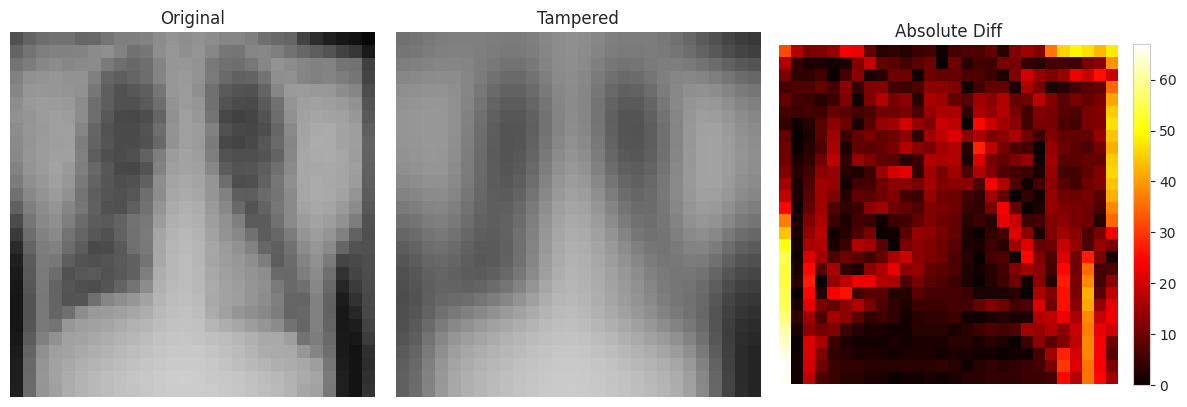

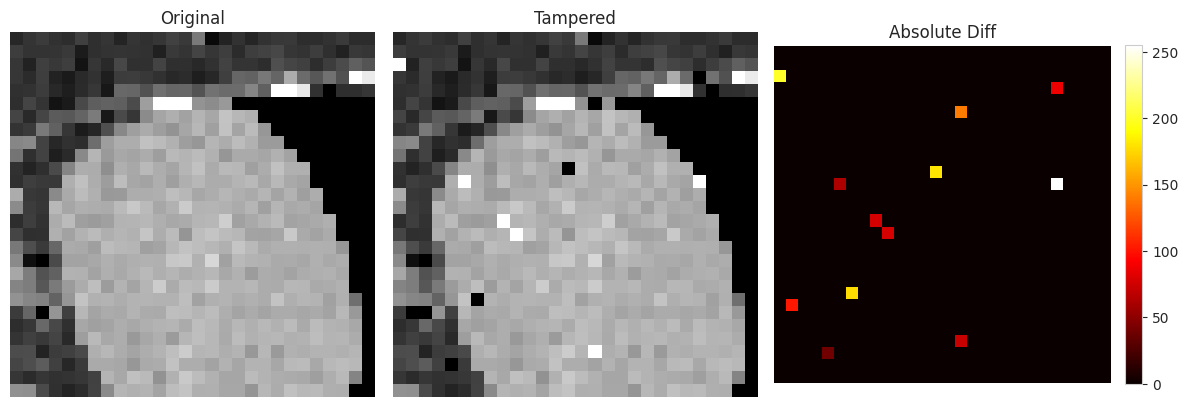

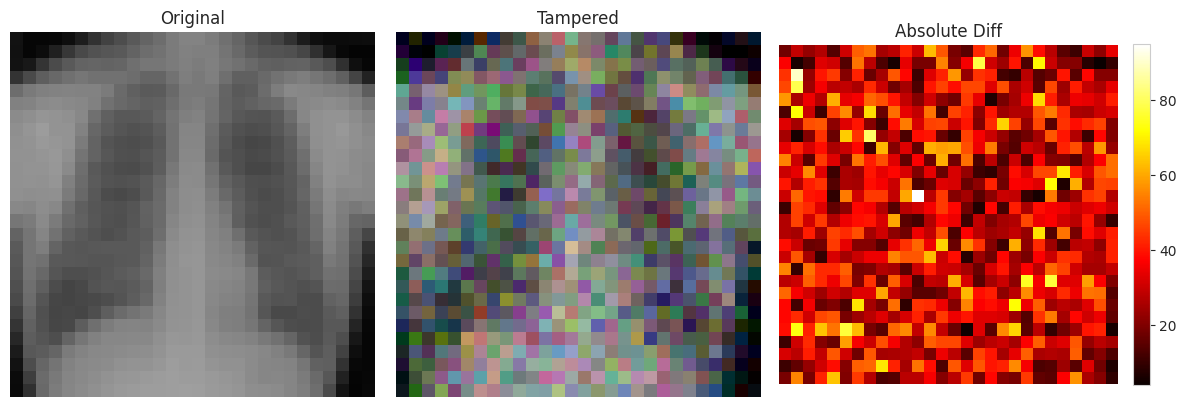

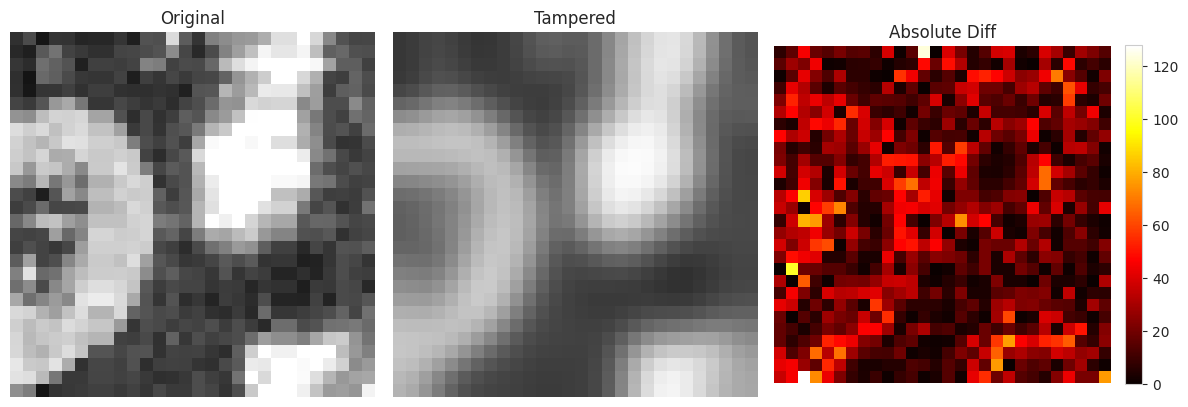

In [11]:
N = X.shape[0]
idxs = np.random.choice(N, size=5, replace=False)

for i in idxs:
    orig = X[i].astype(np.uint8)
    tamp = X_tampered[i].astype(np.uint8)
    diff = np.abs(tamp.astype(float) - orig.astype(float)).max(axis=2)

    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(tamp)
    axes[1].set_title("Tampered")
    axes[1].axis("off")

    im = axes[2].imshow(diff, cmap="hot")
    axes[2].set_title("Absolute Diff")
    axes[2].axis("off")
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

### 5. Channel-wise Boxplots of Per-Image Mean & Std


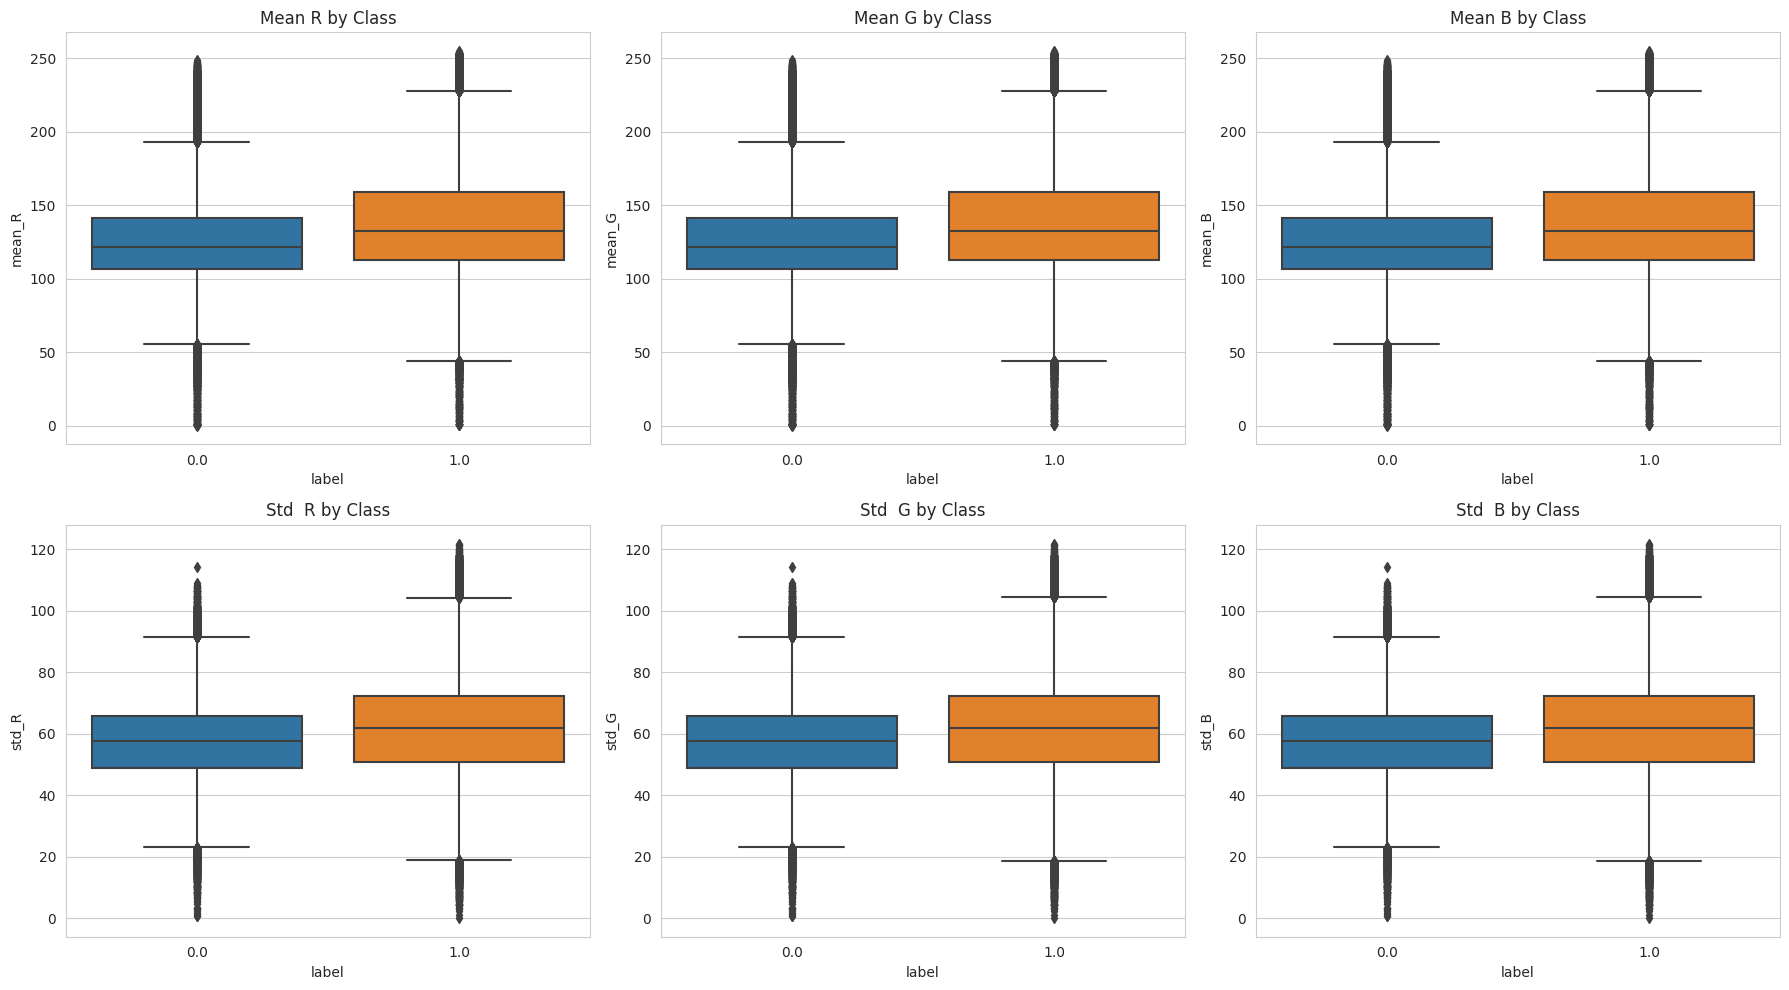

In [12]:
stats = []
for img, lbl in zip(X_train, y_train):
    flat = img.reshape(-1, 3)
    m = flat.mean(axis=0)
    s = flat.std(axis=0)
    stats.append({
        'label': lbl,
        'mean_R': m[0], 'mean_G': m[1], 'mean_B': m[2],
        'std_R': s[0],  'std_G': s[1],  'std_B': s[2]
    })
df_stats = pd.DataFrame(stats)

fig, axes = plt.subplots(2, 3, figsize=(18,10))
sns.boxplot(data=df_stats, x='label', y='mean_R', ax=axes[0,0]).set_title('Mean R by Class')
sns.boxplot(data=df_stats, x='label', y='mean_G', ax=axes[0,1]).set_title('Mean G by Class')
sns.boxplot(data=df_stats, x='label', y='mean_B', ax=axes[0,2]).set_title('Mean B by Class')
sns.boxplot(data=df_stats, x='label', y='std_R',  ax=axes[1,0]).set_title('Std  R by Class')
sns.boxplot(data=df_stats, x='label', y='std_G',  ax=axes[1,1]).set_title('Std  G by Class')
sns.boxplot(data=df_stats, x='label', y='std_B',  ax=axes[1,2]).set_title('Std  B by Class')
plt.tight_layout()
plt.show()

### 6. Average Fourier Power Spectrum (Grayscale)


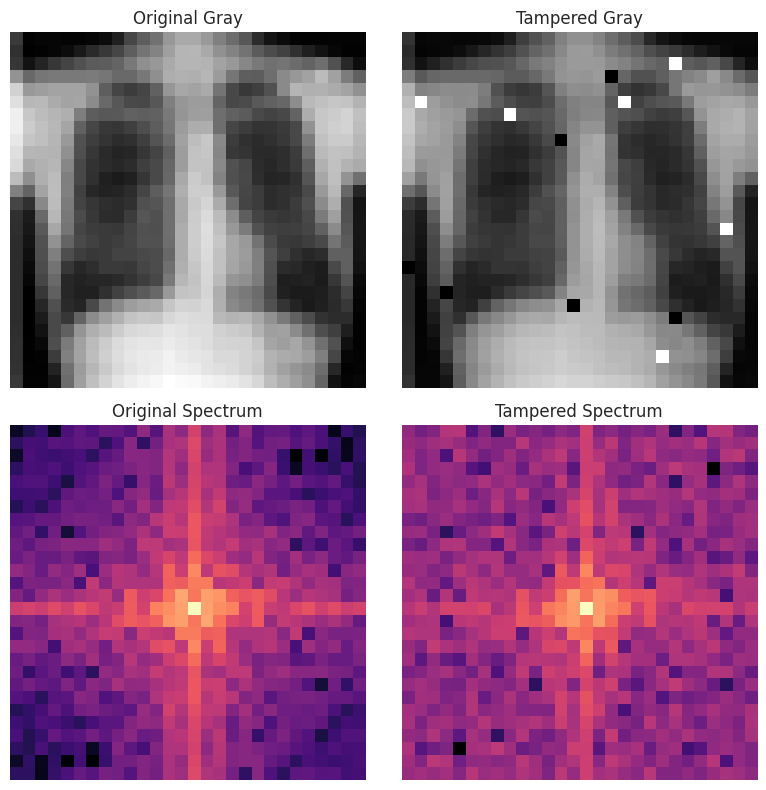

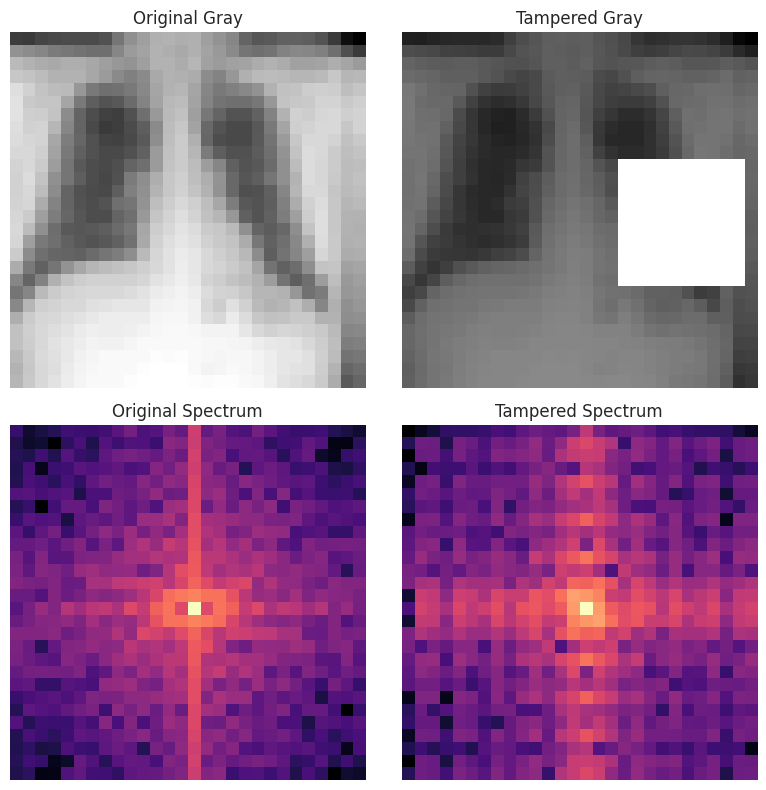

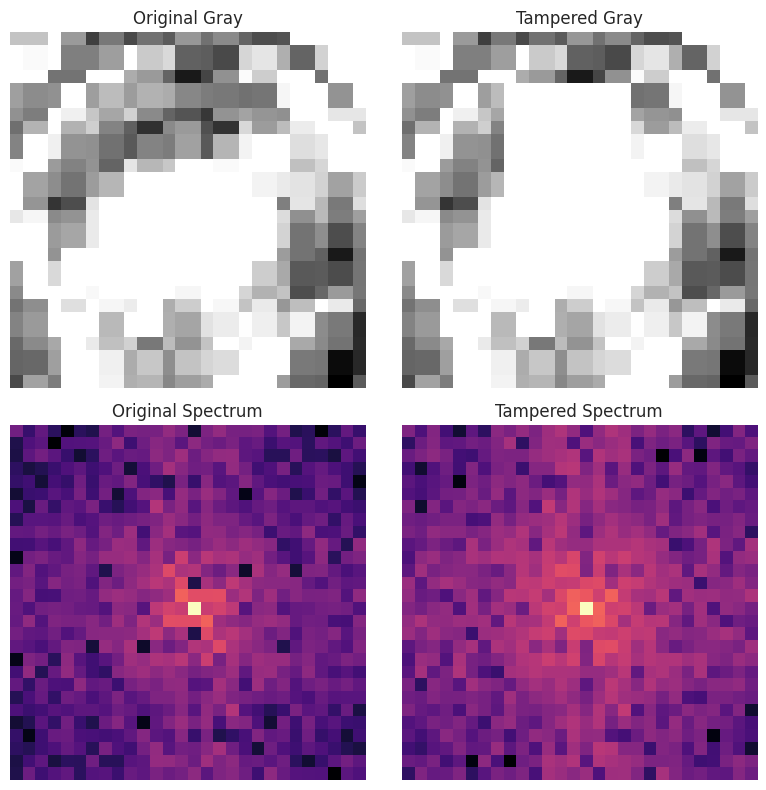

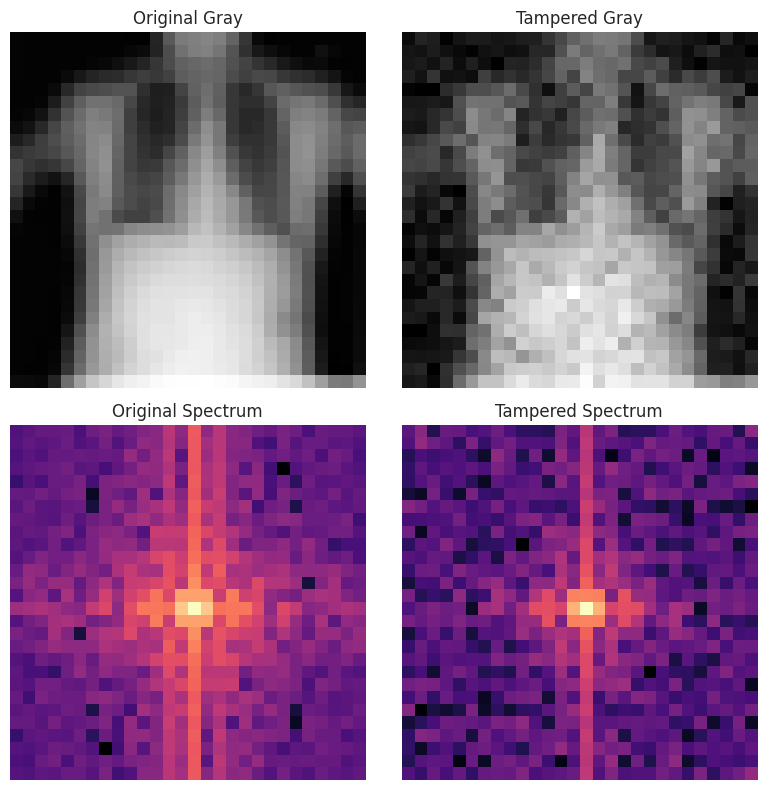

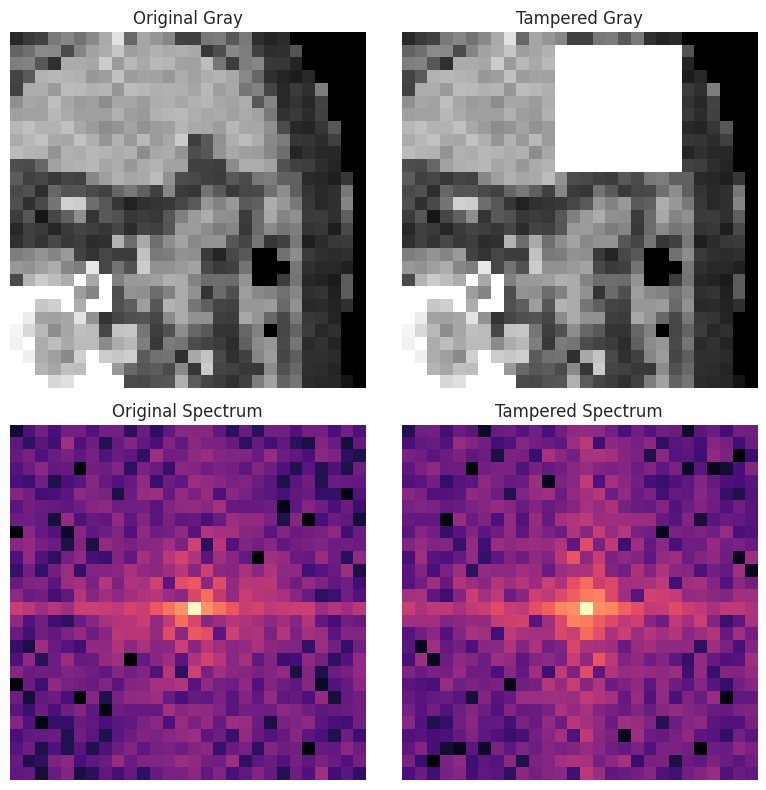

In [13]:
# Spatially, you can visually verify where the patch landed.
# Spectrally, you see that single patches only make a tiny dent in the overall power distribution—hence why your two spectra look almost identical.

N = X.shape[0]
indices = np.random.choice(N, size=5, replace=False)

for i in indices:
    orig = X[i].astype(float)
    tamp = X_tampered[i].astype(float)

    orig_gray = orig.mean(axis=2)
    tamp_gray = tamp.mean(axis=2)

    f_orig  = fftshift(fft2(orig_gray))
    f_tamp  = fftshift(fft2(tamp_gray))
    spec_orig = np.log1p(np.abs(f_orig))
    spec_tamp = np.log1p(np.abs(f_tamp))

    fig, axes = plt.subplots(2, 2, figsize=(8,8))

    axes[0,0].imshow(orig_gray, cmap='gray')
    axes[0,0].set_title('Original Gray')
    axes[0,0].axis('off')

    axes[0,1].imshow(tamp_gray, cmap='gray')
    axes[0,1].set_title('Tampered Gray')
    axes[0,1].axis('off')

    axes[1,0].imshow(spec_orig, cmap='magma')
    axes[1,0].set_title('Original Spectrum')
    axes[1,0].axis('off')

    axes[1,1].imshow(spec_tamp, cmap='magma')
    axes[1,1].set_title('Tampered Spectrum')
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()


# Tensors & DataLoader

In [14]:
# convert to torch.Tensor, permute to (N,3,H,W) and normalize to [0,1]
X_train_t = torch.from_numpy(X_train).permute(0,3,1,2).float()/255.
X_test_t  = torch.from_numpy(X_test).permute(0,3,1,2).float()/255.
y_train_t = torch.from_numpy(y_train).long()
y_test_t  = torch.from_numpy(y_test).long()

In [15]:
# wrap in TensorDataset and DataLoader
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0)

print(f"Train set:      {len(train_ds)} samples")
print(f"Test set:       {len(test_ds)} samples")

Train set:      295785 samples
Test set:       98595 samples


# Model Definitions

In [16]:
_, C, H, W = X_train_t.shape
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. CNN

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,  32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

cnn_model      = SimpleCNN().to(device)
cnn_optimizer  = torch.optim.Adam(cnn_model.parameters(),lr=1e-3, weight_decay=1e-5)

print("\nSimple CNN Model:\n", cnn_model)


Simple CNN Model:
 SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


### 2. ResNet-50

In [18]:
resnet_backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for name, param in resnet_backbone.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False

num_ftrs = resnet_backbone.fc.in_features
resnet_backbone.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)

resnet_model     = resnet_backbone.to(device)
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4, weight_decay=1e-5)

print("\nResNet-50 with custom head:\n", resnet_model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]



ResNet-50 with custom head:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, k

### 3. DenseNet 121

In [19]:
densenet_backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
for name, param in densenet_backbone.named_parameters():
    if "features.norm5" not in name:
        param.requires_grad = False

densenet_backbone.features.conv0 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
densenet_backbone.features.pool0 = nn.Identity()

num_ftrs = densenet_backbone.classifier.in_features
densenet_backbone.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, 2)
)

densenet_model     = densenet_backbone.to(device)
densenet_optimizer = torch.optim.Adam(densenet_model.parameters(), lr=1e-4, weight_decay=1e-5)

print("\nDenseNet-121 with custom head:\n", densenet_model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 167MB/s] 



DenseNet-121 with custom head:
 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): Identity()
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        

# Model Training

### 1. Loss & Hyperparams

In [20]:
num_epochs = 15 
k_folds = 5         

criterion = nn.CrossEntropyLoss()

### 2. Model fitting function

In [21]:
def fit(model_name, model, optimizer, train_loader, val_loader, 
        epochs=10, patience=3, min_delta=1e-4):
    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    best_val_loss     = float('inf')
    best_weights      = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    
    for epoch in range(1, epochs+1):
        # ——— Train ———
        model.train()
        tloss, tacc, total = 0.0, 0, 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb)
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            tloss += loss.item() * yb.size(0)
            preds = logits.argmax(1)
            tacc  += (preds == yb).sum().item()
            total += yb.size(0)

        train_losses.append(tloss/total)
        train_accs.append(tacc/total)

        # ——— Validate ———
        model.eval()
        vloss, vacc, total = 0.0, 0, 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                logits = model(Xb)
                loss   = criterion(logits, yb)
                vloss += loss.item() * yb.size(0)
                preds = logits.argmax(1)
                vacc  += (preds == yb).sum().item()
                total += yb.size(0)

        val_losses.append(vloss/total)
        val_accs.append(vacc/total)

        print(f"Epoch {epoch}/{epochs}  "
              f"train_loss={train_losses[-1]:.4f}, train_acc={train_accs[-1]:.4f}  |  "
              f"val_loss={val_losses[-1]:.4f},   val_acc={val_accs[-1]:.4f}")

        # ——— Early Stopping Check ———
        if val_losses[-1] + min_delta < best_val_loss:
            best_val_loss     = val_losses[-1]
            best_weights      = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  → No improvement for {epochs_no_improve} epochs")
            if epochs_no_improve >= patience:
                print(f"Stopping early at epoch {epoch}")
                break

    # restore best weights
    model.load_state_dict(best_weights)

    return {
        'train_losses': train_losses,
        'val_losses':   val_losses,
        'train_accs':   train_accs,
        'val_accs':     val_accs
    }


### 3. Cross validation function

In [22]:
def cross_validate(model_name, model, optimizer, train_ds,
                   X_train, y_train, device, fit_fn, k_folds=5, 
                   epochs=15, batch_size=32):

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    train_accs = []
    val_accs   = []
    train_losses = []
    val_losses   = []
    
    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), 1):
        print(f"\n============================ Training {model_name} Fold {fold}/{k_folds} ===================================")

        tr_sub = Subset(train_ds, tr_idx)
        va_sub = Subset(train_ds, va_idx)
        tr_ld  = DataLoader(tr_sub, batch_size=batch_size, shuffle=True,  num_workers=0)
        va_ld  = DataLoader(va_sub, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # train!
        hist = fit_fn(model_name, model, optimizer, tr_ld, va_ld, epochs=epochs)

        for key in ('train_accs','val_accs','train_losses','val_losses'):
            L = hist[key]
            if len(L) < epochs:
                L.extend([L[-1]]*(epochs - len(L)))
            hist[key] = L 
            
        train_accs.append(hist['train_accs'])
        val_accs.append(  hist['val_accs'])
        train_losses.append(hist['train_losses'])
        val_losses.append(  hist['val_losses'])
    
    train_accs   = np.array(train_accs)
    val_accs     = np.array(val_accs)
    train_losses = np.array(train_losses)
    val_losses   = np.array(val_losses)
    
    result = {
        'train_acc_mean':   train_accs.mean(axis=0),
        'train_acc_std':    train_accs.std(axis=0),
        'val_acc_mean':     val_accs.mean(axis=0),
        'val_acc_std':      val_accs.std(axis=0),
        'train_loss_mean':  train_losses.mean(axis=0),
        'train_loss_std':   train_losses.std(axis=0),
        'val_loss_mean':    val_losses.mean(axis=0),
        'val_loss_std':     val_losses.std(axis=0),
        'epochs':           np.arange(1, train_accs.shape[1]+1)
    }
    return result

### 5. Train Simple CNN model 

In [23]:
cnn_cv = cross_validate("SimpleCNN", cnn_model, cnn_optimizer, train_ds, X_train, y_train, device, fit, k_folds=k_folds, epochs=num_epochs)


============================ Training SimpleCNN Fold 1/5 ===================================
Epoch 1/15  train_loss=0.1737, train_acc=0.9285  |  val_loss=0.0822,   val_acc=0.9686
Epoch 2/15  train_loss=0.0923, train_acc=0.9659  |  val_loss=0.0660,   val_acc=0.9750
Epoch 3/15  train_loss=0.0705, train_acc=0.9741  |  val_loss=0.0544,   val_acc=0.9801
Epoch 4/15  train_loss=0.0621, train_acc=0.9775  |  val_loss=0.0465,   val_acc=0.9826
Epoch 5/15  train_loss=0.0524, train_acc=0.9810  |  val_loss=0.0504,   val_acc=0.9818
  → No improvement for 1 epochs
Epoch 6/15  train_loss=0.0452, train_acc=0.9838  |  val_loss=0.0592,   val_acc=0.9777
  → No improvement for 2 epochs
Epoch 7/15  train_loss=0.0410, train_acc=0.9851  |  val_loss=0.0425,   val_acc=0.9857
Epoch 8/15  train_loss=0.0387, train_acc=0.9862  |  val_loss=0.0480,   val_acc=0.9828
  → No improvement for 1 epochs
Epoch 9/15  train_loss=0.0362, train_acc=0.9872  |  val_loss=0.0407,   val_acc=0.9857
Epoch 10/15  train_loss=0.0379, trai

###  6. Train ResNet 50 model

In [24]:
resnet_cv = cross_validate("ResNet-50", resnet_model, resnet_optimizer, train_ds, X_train, y_train, device, fit, k_folds=k_folds, epochs=num_epochs)


============================ Training ResNet-50 Fold 1/5 ===================================
Epoch 1/15  train_loss=0.2072, train_acc=0.9125  |  val_loss=0.1418,   val_acc=0.9408
Epoch 2/15  train_loss=0.1486, train_acc=0.9388  |  val_loss=0.1334,   val_acc=0.9483
Epoch 3/15  train_loss=0.1273, train_acc=0.9478  |  val_loss=0.1254,   val_acc=0.9485
Epoch 4/15  train_loss=0.1157, train_acc=0.9527  |  val_loss=0.1204,   val_acc=0.9511
Epoch 5/15  train_loss=0.1060, train_acc=0.9567  |  val_loss=0.1712,   val_acc=0.9512
  → No improvement for 1 epochs
Epoch 6/15  train_loss=0.0971, train_acc=0.9606  |  val_loss=0.1408,   val_acc=0.9508
  → No improvement for 2 epochs
Epoch 7/15  train_loss=0.0903, train_acc=0.9632  |  val_loss=0.1272,   val_acc=0.9499
  → No improvement for 3 epochs
Stopping early at epoch 7

============================ Training ResNet-50 Fold 2/5 ===================================
Epoch 1/15  train_loss=0.1123, train_acc=0.9544  |  val_loss=0.0898,   val_acc=0.9644
Ep

### 7. Train DenseNet121 model

In [25]:
densenet_cv = cross_validate("DenseNet-121",densenet_model,densenet_optimizer,train_ds, X_train, y_train, device, fit, k_folds=k_folds, epochs=num_epochs)


============================ Training DenseNet-121 Fold 1/5 ===================================
Epoch 1/15  train_loss=0.2744, train_acc=0.8812  |  val_loss=0.1564,   val_acc=0.9372
Epoch 2/15  train_loss=0.1745, train_acc=0.9302  |  val_loss=0.1228,   val_acc=0.9509
Epoch 3/15  train_loss=0.1509, train_acc=0.9404  |  val_loss=0.1122,   val_acc=0.9568
Epoch 4/15  train_loss=0.1373, train_acc=0.9462  |  val_loss=0.1011,   val_acc=0.9608
Epoch 5/15  train_loss=0.1297, train_acc=0.9493  |  val_loss=0.0985,   val_acc=0.9606
Epoch 6/15  train_loss=0.1229, train_acc=0.9520  |  val_loss=0.0891,   val_acc=0.9658
Epoch 7/15  train_loss=0.1180, train_acc=0.9542  |  val_loss=0.0893,   val_acc=0.9656
  → No improvement for 1 epochs
Epoch 8/15  train_loss=0.1130, train_acc=0.9563  |  val_loss=0.0814,   val_acc=0.9693
Epoch 9/15  train_loss=0.1084, train_acc=0.9581  |  val_loss=0.0861,   val_acc=0.9670
  → No improvement for 1 epochs
Epoch 10/15  train_loss=0.1072, train_acc=0.9590  |  val_loss=0.0

# Model evalutions

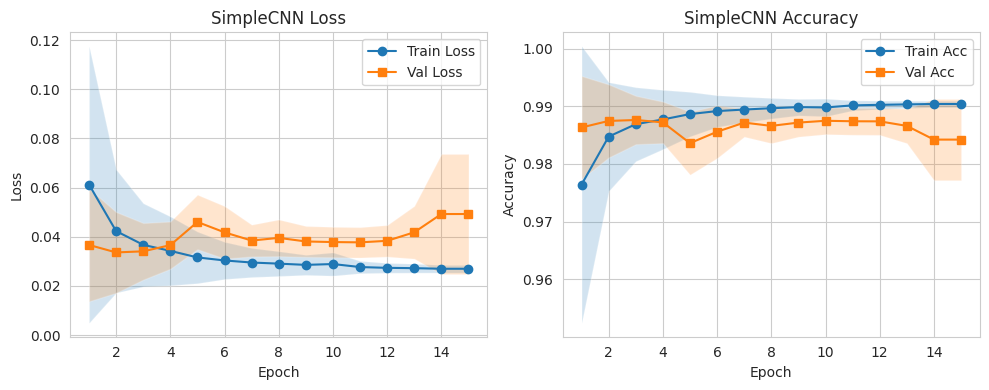

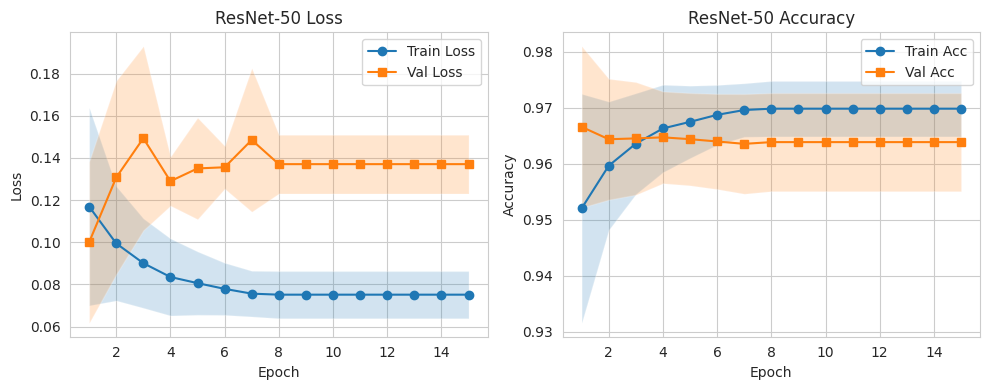

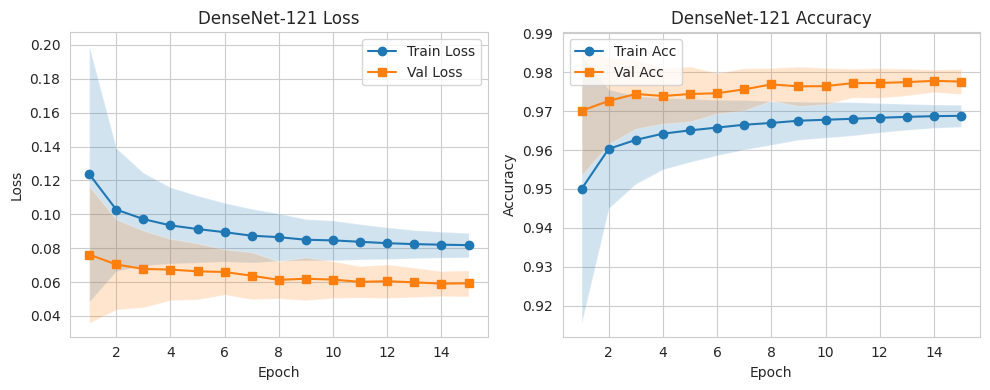

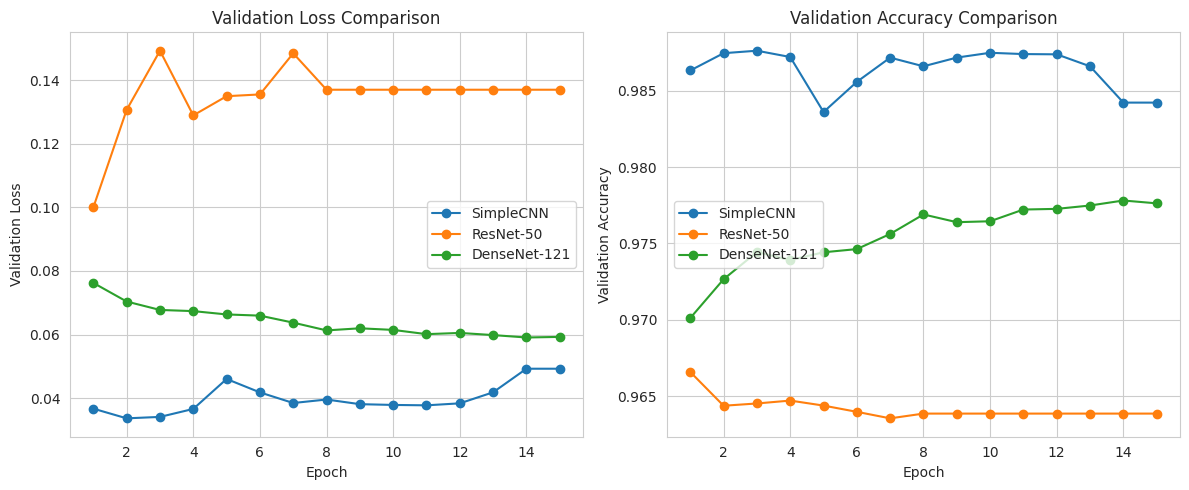

In [26]:
models = [
    ("SimpleCNN",  cnn_cv),
    ("ResNet-50",  resnet_cv),
    ("DenseNet-121", densenet_cv)
]

# 1. Individual plots
for name, cv in models:
    epochs = cv['epochs']
    # Loss plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, cv['train_loss_mean'], '-o', label='Train Loss')
    plt.fill_between(epochs,
                     cv['train_loss_mean'] - cv['train_loss_std'],
                     cv['train_loss_mean'] + cv['train_loss_std'],
                     alpha=0.2)
    plt.plot(epochs, cv['val_loss_mean'], '-s', label='Val Loss')
    plt.fill_between(epochs,
                     cv['val_loss_mean'] - cv['val_loss_std'],
                     cv['val_loss_mean'] + cv['val_loss_std'],
                     alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{name} Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1,2,2)
    plt.plot(epochs, cv['train_acc_mean'], '-o', label='Train Acc')
    plt.fill_between(epochs,
                     cv['train_acc_mean'] - cv['train_acc_std'],
                     cv['train_acc_mean'] + cv['train_acc_std'],
                     alpha=0.2)
    plt.plot(epochs, cv['val_acc_mean'], '-s', label='Val Acc')
    plt.fill_between(epochs,
                     cv['val_acc_mean'] - cv['val_acc_std'],
                     cv['val_acc_mean'] + cv['val_acc_std'],
                     alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{name} Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 2. Combined comparison of validation loss & accuracy
plt.figure(figsize=(12,5))

# Val Loss comparison
plt.subplot(1,2,1)
for name, cv in models:
    plt.plot(epochs, cv['val_loss_mean'], '-o', label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

# Val Accuracy comparison
plt.subplot(1,2,2)
for name, cv in models:
    plt.plot(epochs, cv['val_acc_mean'], '-o', label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Model Prediction

In [27]:
def get_preds_probs(model, loader):
    model.eval()
    all_true, all_pred, all_prob = [], [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)
            probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()  # probability of “Tampered”
            preds = logits.argmax(dim=1).cpu().numpy()
            all_true.extend(yb.numpy())
            all_pred.extend(preds)
            all_prob.extend(probs)
    return np.array(all_true), np.array(all_pred), np.array(all_prob)

# Results


================================= SimpleCNN Binary Evaluation ====================================


,n,accuracy,precision,recall,f1
technique,,,,,
blur,9888,0.987257,0.989758,0.984515,0.987130
contrast,9712,0.986306,0.989760,0.983116,0.986427
gaussian_noise,9956,0.985034,0.991055,0.978916,0.984948
original,49298,0.988235,0.992157,0.984155,0.988140
patch,9850,0.989036,0.992519,0.985743,0.989119
salt_pepper,9891,0.986958,0.991258,0.982668,0.986945


              precision    recall  f1-score   support

    Original       0.98      0.99      0.99     49298
    Tampered       0.99      0.98      0.99     49297

    accuracy                           0.99     98595
   macro avg       0.99      0.99      0.99     98595
weighted avg       0.99      0.99      0.99     98595



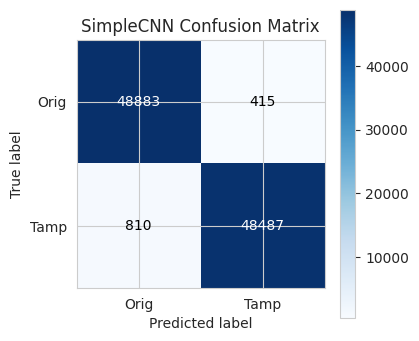

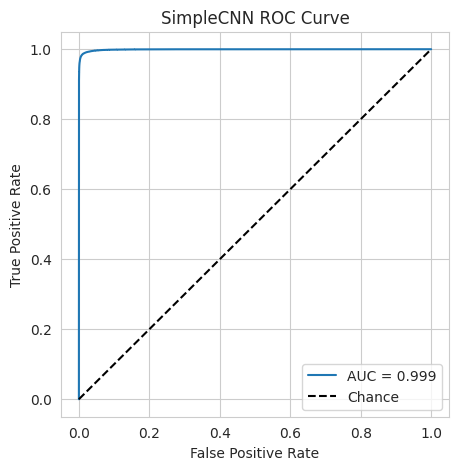


================================= ResNet-50 Binary Evaluation ====================================


,n,accuracy,precision,recall,f1
technique,,,,,
blur,9888,0.951760,0.963962,0.937295,0.950442
contrast,9712,0.953151,0.968997,0.938344,0.953424
gaussian_noise,9956,0.953596,0.966267,0.939815,0.952857
original,49298,0.951398,0.964286,0.937637,0.950775
patch,9850,0.952487,0.964316,0.939084,0.951533
salt_pepper,9891,0.953999,0.966339,0.940195,0.953088


              precision    recall  f1-score   support

    Original       0.94      0.97      0.95     49298
    Tampered       0.97      0.94      0.95     49297

    accuracy                           0.95     98595
   macro avg       0.95      0.95      0.95     98595
weighted avg       0.95      0.95      0.95     98595



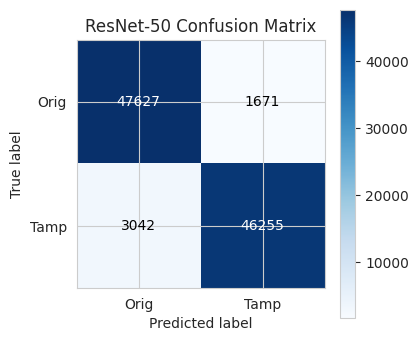

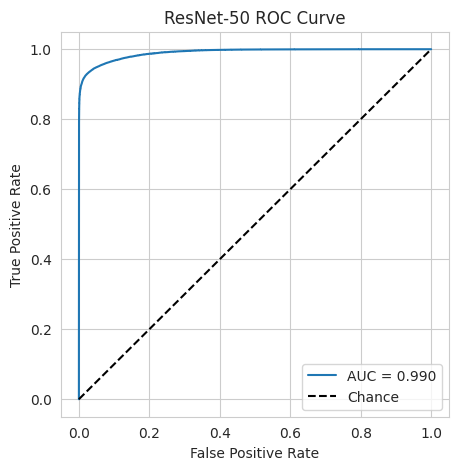


================================= DenseNet-121 Binary Evaluation ====================================


,n,accuracy,precision,recall,f1
technique,,,,,
blur,9888,0.978256,0.982066,0.974323,0.978179
contrast,9712,0.978892,0.985549,0.972499,0.978981
gaussian_noise,9956,0.976898,0.984543,0.969169,0.976796
original,49298,0.977220,0.982421,0.971764,0.977063
patch,9850,0.973299,0.981386,0.964823,0.973034
salt_pepper,9891,0.976544,0.983082,0.969481,0.976234


              precision    recall  f1-score   support

    Original       0.97      0.98      0.98     49298
    Tampered       0.98      0.97      0.98     49297

    accuracy                           0.98     98595
   macro avg       0.98      0.98      0.98     98595
weighted avg       0.98      0.98      0.98     98595



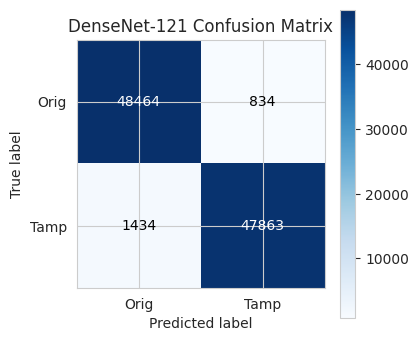

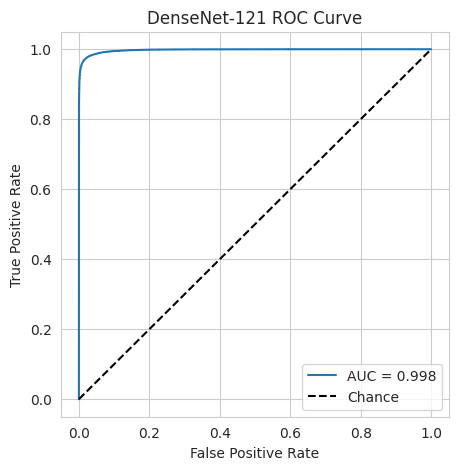

In [28]:
models = [
    ("SimpleCNN",   cnn_model),
    ("ResNet-50",   resnet_model),
    ("DenseNet-121", densenet_model),
]

technique_labels = tech_test  
unique_techs = np.unique(technique_labels)

for name, mdl in models:
    y_true, y_pred, y_prob = get_preds_probs(mdl, test_loader)

    print(f"\n================================= {name} Binary Evaluation ====================================")
    
    # 0.Per-Technique Metrics
    rows = []
    for tech in unique_techs:
        mask = (technique_labels == tech)
        yt, yp = y_true[mask], y_pred[mask]
        if len(yt) == 0:
            continue
        rows.append({
            'technique': tech,
            'n'        : len(yt),
            'accuracy' : accuracy_score(yt, yp),
            'precision': precision_score(yt, yp, zero_division=0),
            'recall'   : recall_score(yt, yp, zero_division=0),
            'f1'       : f1_score(yt, yp, zero_division=0)
        })
    
    df_metrics = pd.DataFrame(rows)
    df_metrics = df_metrics.set_index('technique')
    display(df_metrics)
    
    # f1s = []
    # for tech in unique_techs:
    #     mask = (technique_labels == tech)
    #     yt, yp = y_true[mask], y_pred[mask]
    #     f1s.append(f1_score(yt, yp) if len(yt)>0 else 0)
    
    # print("Per-Technique Metrics:\n")
    # plt.figure(figsize=(6,4))
    # plt.bar(unique_techs, f1s, color='C2')
    # plt.xticks(rotation=45)
    # plt.ylabel("F1 Score")
    # plt.title("F1-Score by Tampering Technique")
    # plt.ylim(0,1)
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.show()
    
    # 1. Classification report (Original=0, Tampered=1)
    print(classification_report(
        y_true, y_pred,
        target_names=["Original","Tampered"]
    ))
    
    # 2. Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xticks([0,1], ["Orig","Tamp"])
    plt.yticks([0,1], ["Orig","Tamp"])
    for i in [0,1]:
        for j in [0,1]:
            plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.show()
    
    # 3. ROC AUC and curve
    auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],"k--", label="Chance")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Grad-CAM visualizations for interpretability

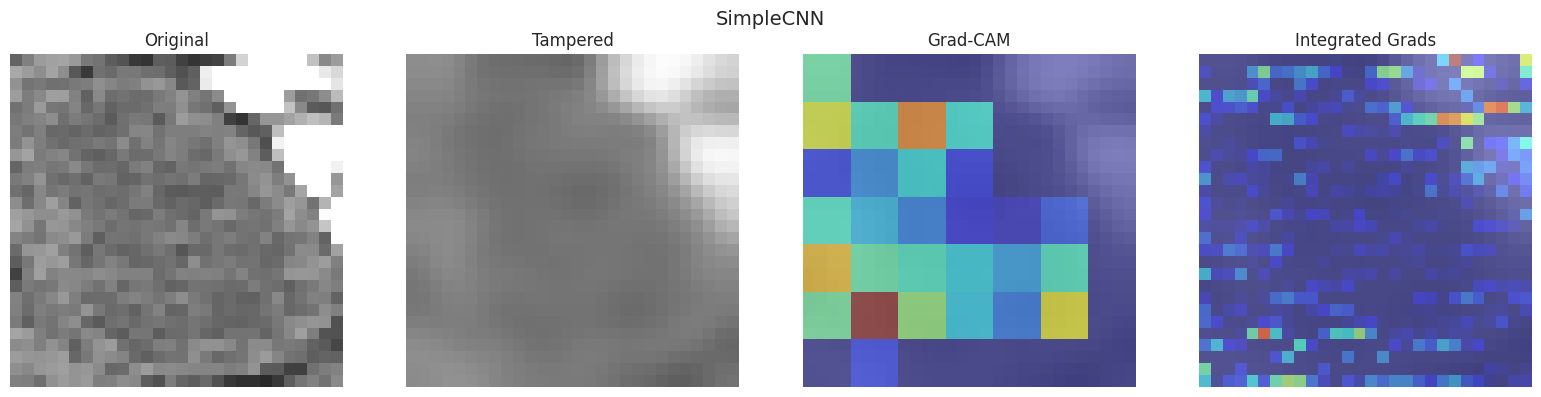

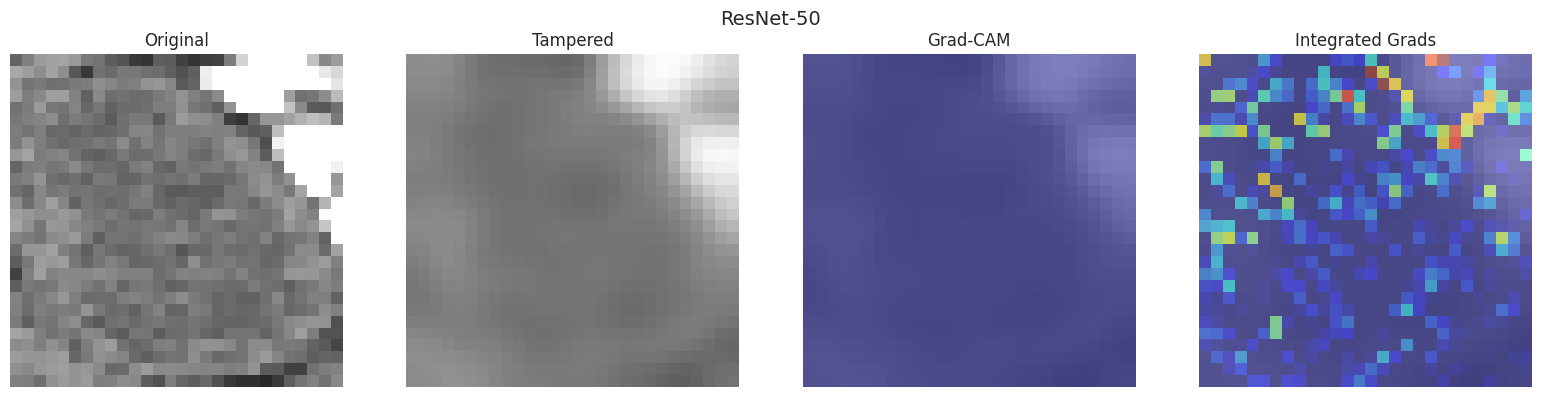

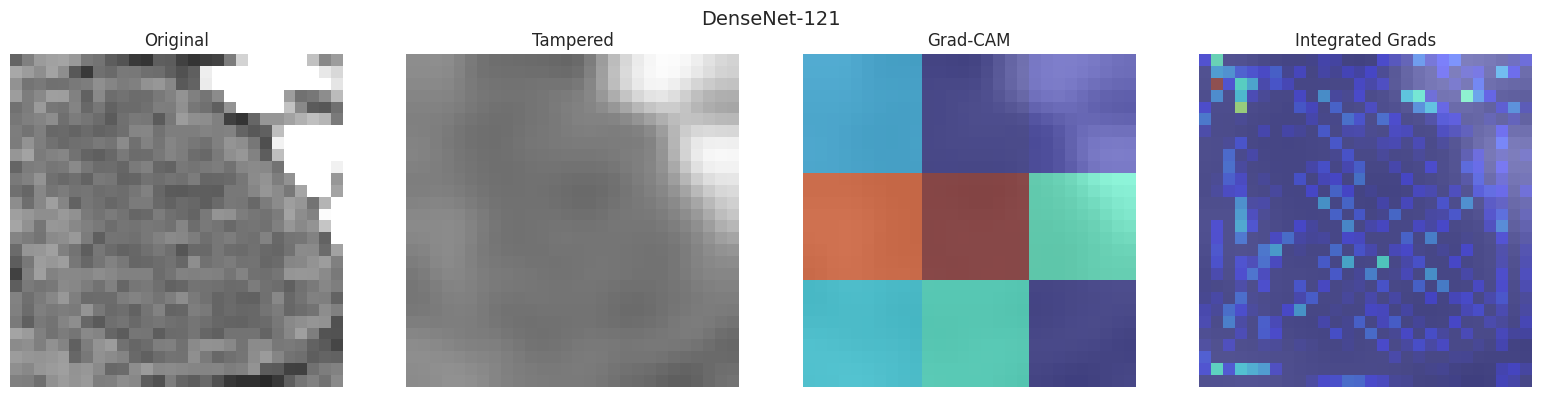

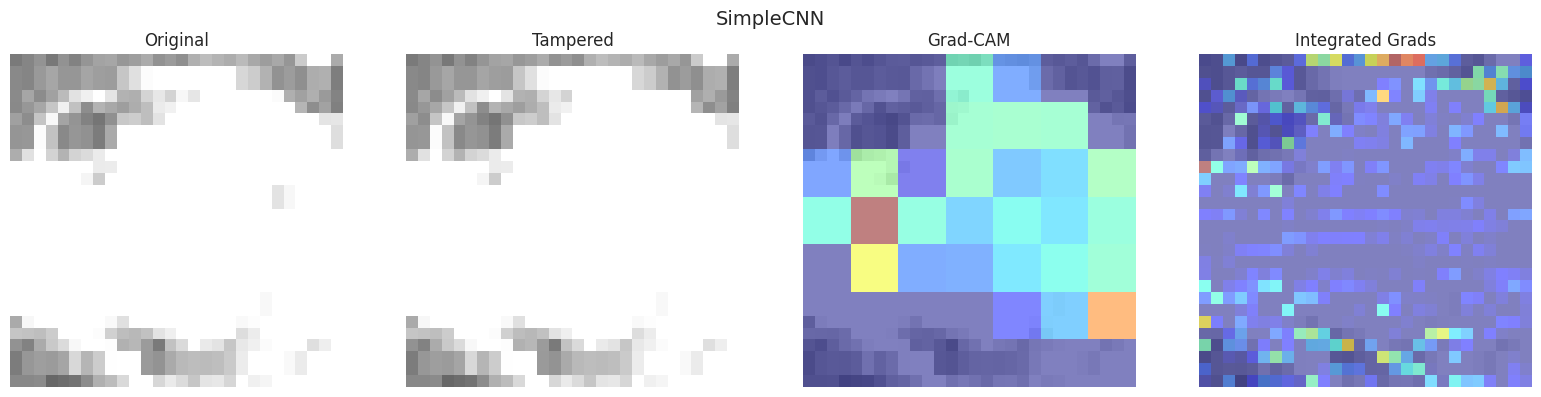

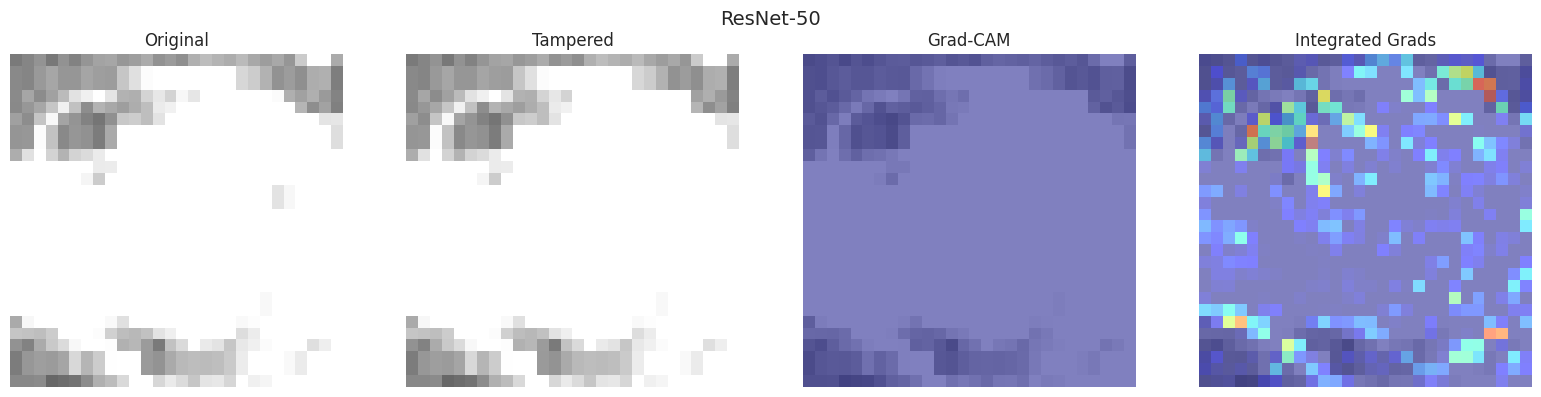

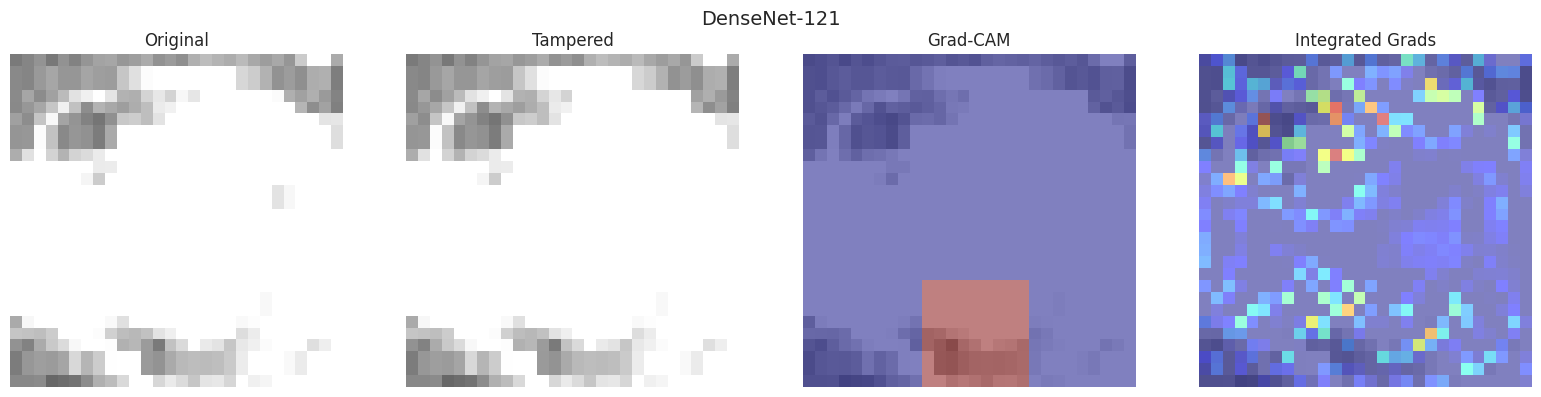

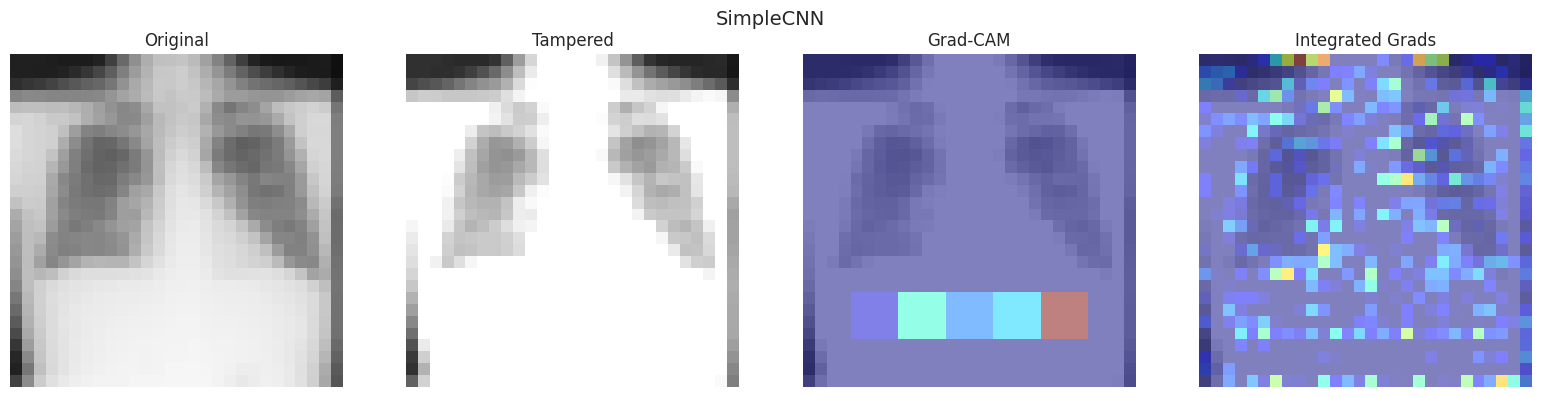

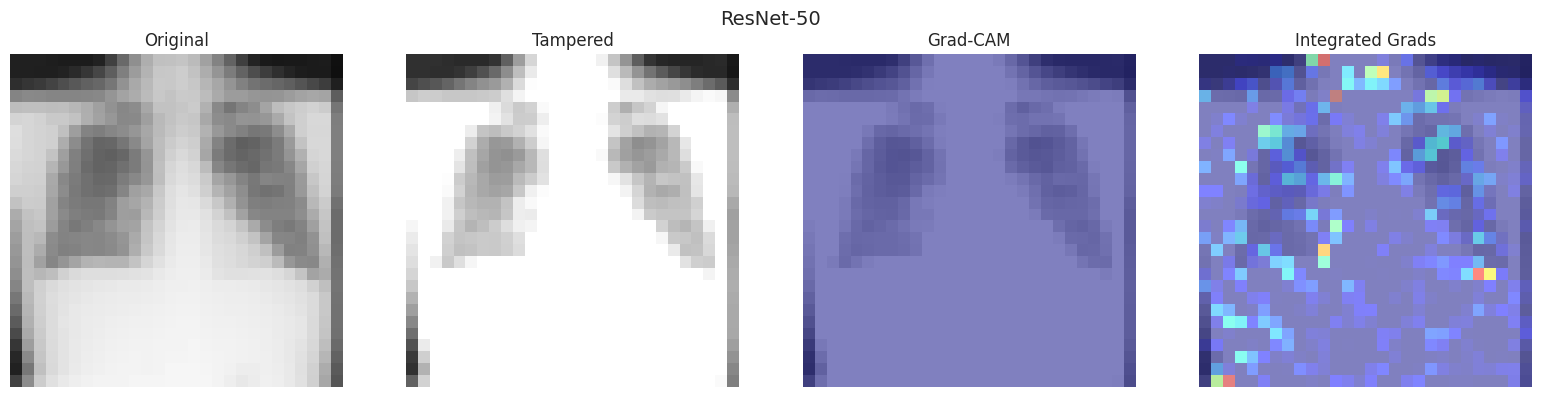

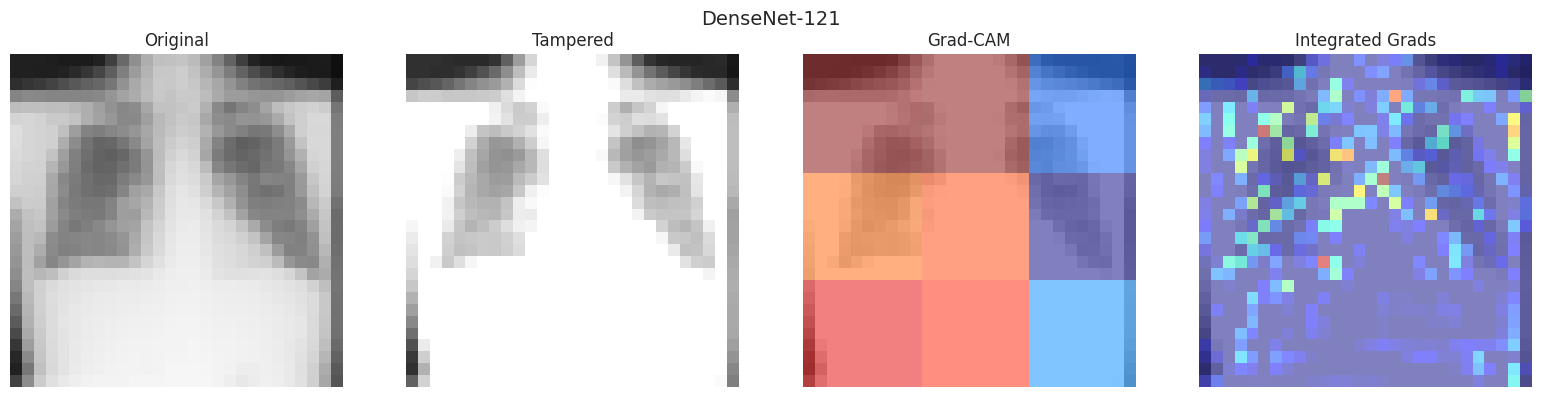

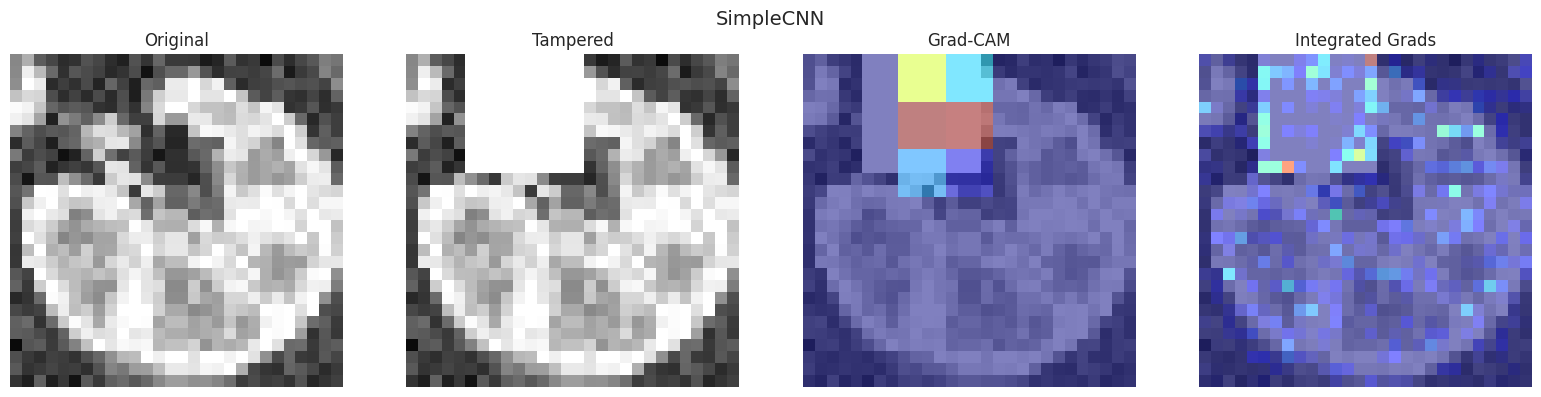

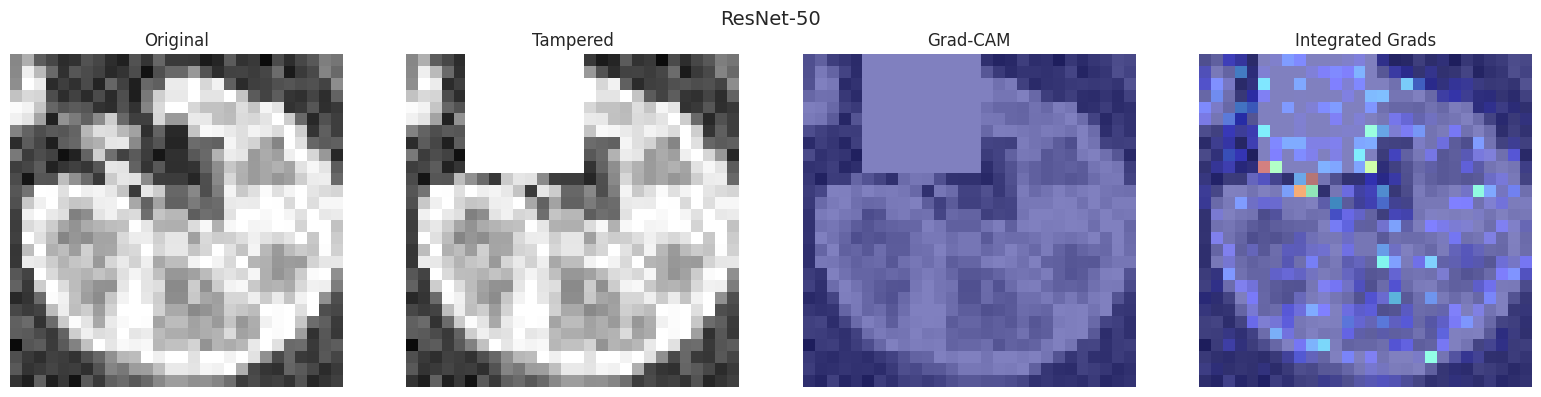

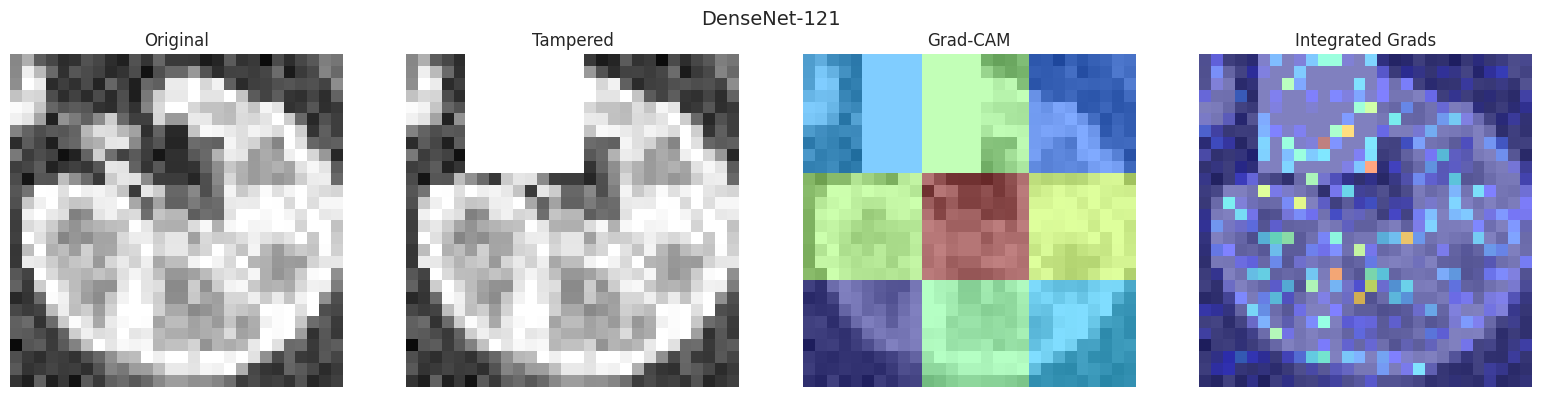

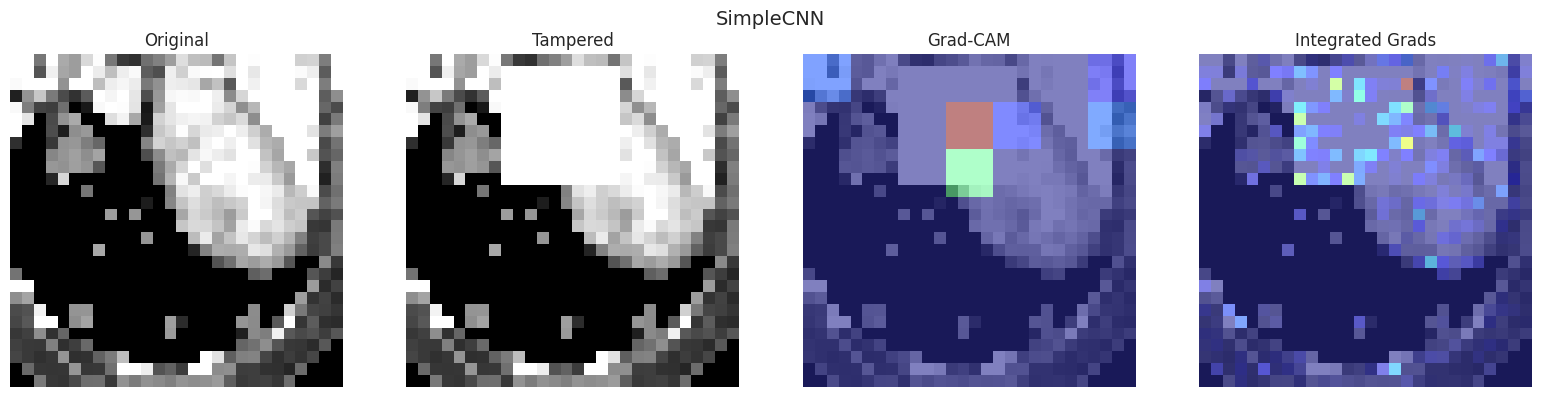

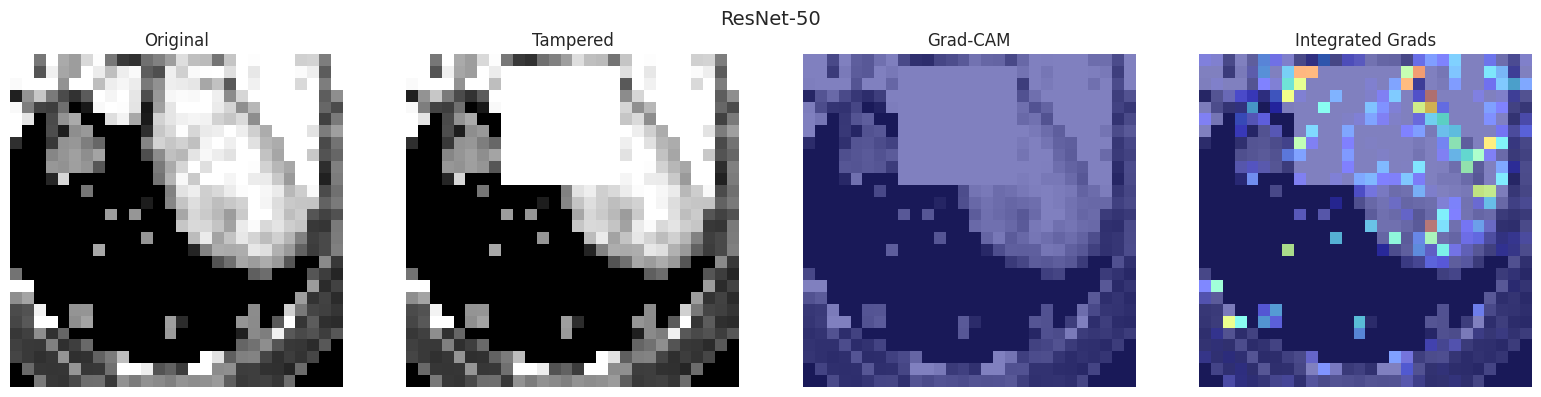

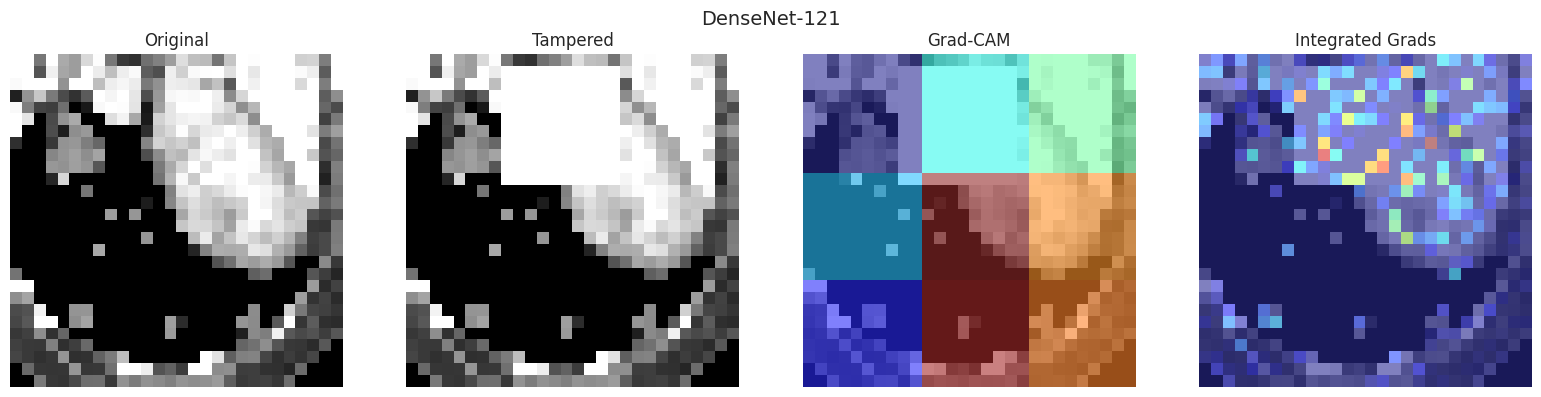

In [29]:
def show_pair_and_attr(model, layer, orig_img, tamp_img, title):
    model.eval()
    inp = (torch.from_numpy(tamp_img)
              .permute(2,0,1)
              .unsqueeze(0)
              .float()
              .to(device) / 255.)

    # Grad-CAM via Captum
    gc = LayerGradCam(model, layer)
    gc_attr     = gc.attribute(inp, target=1)
    gc_up       = LayerAttribution.interpolate(gc_attr, inp.shape[2:])
    gc_map      = gc_up.squeeze(0).sum(0).cpu().clamp(min=0).detach().numpy()
    gc_map     /= (gc_map.max() + 1e-8)

    # Integrated Gradients via Captum
    ig = IntegratedGradients(model)
    baseline    = torch.zeros_like(inp)
    ig_attr     = ig.attribute(inp, baselines=baseline, target=1, n_steps=50)
    ig_map      = ig_attr.squeeze(0).sum(0).cpu().clamp(min=0).detach().numpy()
    ig_map     /= (ig_map.max() + 1e-8)

    # Plot
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    axes[0].imshow(orig_img.astype(np.uint8));      axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(tamp_img.astype(np.uint8));      axes[1].set_title("Tampered"); axes[1].axis("off")
    axes[2].imshow(tamp_img.astype(np.uint8), alpha=0.8)
    axes[2].imshow(gc_map, cmap='jet', alpha=0.5);   axes[2].set_title("Grad-CAM"); axes[2].axis("off")
    axes[3].imshow(tamp_img.astype(np.uint8), alpha=0.8)
    axes[3].imshow(ig_map, cmap='jet', alpha=0.5);   axes[3].set_title("Integrated Grads"); axes[3].axis("off")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

N = X.shape[0]
idxs = random.sample(range(N), 5)

for idx in idxs:
    orig_img = X[idx]
    tamp_img = X_tampered[idx]

    # CNN
    cnn_layer = cnn_model.features[6]
    show_pair_and_attr(cnn_model, cnn_layer, orig_img, tamp_img, "SimpleCNN")

    # ResNet
    resnet_layer = dict(resnet_model.named_modules())['layer4.2.conv3']
    show_pair_and_attr(resnet_model, resnet_layer, orig_img, tamp_img, "ResNet-50")

    # DenseNet
    densenet_layer = dict(densenet_model.named_modules())[
        'features.denseblock4.denselayer16.conv2'
    ]
    show_pair_and_attr(densenet_model, densenet_layer, orig_img, tamp_img, "DenseNet-121")


# Save Models

In [30]:
OUTPUT_DIR = Path("models")
OUTPUT_DIR.mkdir(exist_ok=True)

cnn_path = OUTPUT_DIR / "cnn_state_dict.pth"
torch.save(cnn_model.state_dict(), cnn_path)

resnet_path = OUTPUT_DIR / "resnet_state_dict.pth"
torch.save(resnet_model.state_dict(), resnet_path)

dnet_path = OUTPUT_DIR / "densenet_state_dict.pth"
torch.save(densenet_model.state_dict(), dnet_path)

meta = {
    "classes": ["original", "tampered"],
    "cnn_path": str(cnn_path),
    "resnet_path": str(resnet_path),
    "densenet_path": str(dnet_path)
}
with open(OUTPUT_DIR / "metadata.json", "w") as f:
    json.dump(meta, f)